In [1]:
#!pip install h5py

In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import h5py
import os

train_path = "C:\\Users\\YooNi\\OneDrive\\Desktop\\DSC180A\\MJD_Train_2.hdf5"
test_path  = "C:\\Users\\YooNi\\OneDrive\\Desktop\\DSC180A\\MJD_Test_2.hdf5"  # change if needed

def list_keys(path, label):
    try:
        with h5py.File(path, "r") as f:
            filename = os.path.basename(path)
            print(f"\n=== {label.upper()} FILE: {filename} ===")
            first_key = list(f.keys())[0]
            print("Number of rows:", f[first_key].shape[0])
            print("Columns (datasets):")
            for k in f.keys():
                print("  ", k)
    except Exception as e:
        print(f"{label.capitalize()} file not found or error reading it:", e)

list_keys(train_path, "train")
list_keys(test_path, "test")



=== TRAIN FILE: MJD_Train_2.hdf5 ===
Number of rows: 65000
Columns (datasets):
   detector
   energy_label
   id
   psd_label_dcr
   psd_label_high_avse
   psd_label_low_avse
   psd_label_lq
   raw_waveform
   run_number
   tp0

=== TEST FILE: MJD_Test_2.hdf5 ===
Number of rows: 65000
Columns (datasets):
   detector
   energy_label
   id
   psd_label_dcr
   psd_label_high_avse
   psd_label_low_avse
   psd_label_lq
   raw_waveform
   run_number
   tp0


In [4]:
# file_path = "/Users/lucageorgescu/MJD_data_files/MJD_Train_0.hdf5"
file_path = "C:\\Users\\YooNi\\OneDrive\\Desktop\\DSC180A\\MJD_Train_2.hdf5"

In [5]:
#loads in waveform & data, then chooses random datapoint
with h5py.File(file_path, 'r') as file:
    #load waveform & time index
    raw_waveform = np.array(file["raw_waveform"])
    time_index = np.arange(0,raw_waveform.shape[1])

    #load labels
    energy_label = np.array(file["energy_label"])
    psd_label_low_avse = np.array(file["psd_label_low_avse"])
    psd_label_high_avse = np.array(file["psd_label_high_avse"])
    psd_label_dcr = np.array(file["psd_label_dcr"])
    psd_label_lq = np.array(file["psd_label_lq"])
    tp0 = np.array(file["tp0"])
    detector = np.array(file["detector"])
    run_number = np.array(file["run_number"])
    id = np.array(file["id"])
    
    #choose random datapoint
    random_index = np.random.choice(id.shape[0])

    #get datapoint waveform & labels
    random_waveform = raw_waveform[random_index]
    energy_value = energy_label[random_index]
    psd_low_avse_value = psd_label_low_avse[random_index]
    psd_high_avse_value = psd_label_high_avse[random_index]
    psd_dcr_value = psd_label_dcr[random_index]
    psd_lq_value = psd_label_lq[random_index]
    tp0_value = tp0[random_index]
    detector_value = detector[random_index]
    run_number_value = run_number[random_index]
    id_value = id[random_index]

Data Labels:
Energy: 290.58255272731185
PSD Low Avse: True
PSD High Avse: True
PSD DCR: True
PSD LQ: True
TP0: 943
Detector: 152
Run Number: 32426
ID: 160056


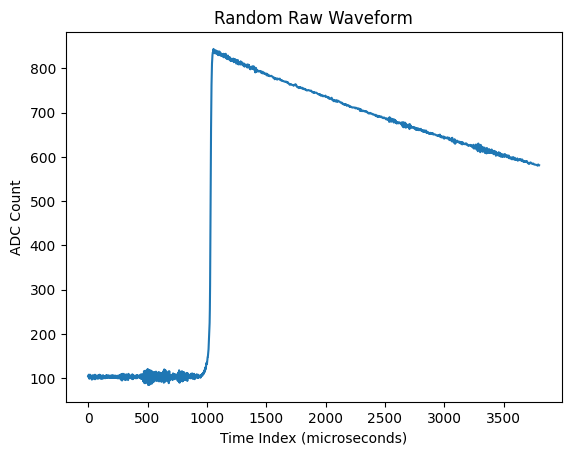

In [6]:
fig, ax = plt.subplots()
ax.plot(time_index, random_waveform)
ax.set_title("Random Raw Waveform")
ax.set_xlabel("Time Index (microseconds)")
ax.set_ylabel("ADC Count")

print("Data Labels:")
print(f"Energy: {energy_value}")
print(f"PSD Low Avse: {psd_low_avse_value}")
print(f"PSD High Avse: {psd_high_avse_value}")
print(f"PSD DCR: {psd_dcr_value}")
print(f"PSD LQ: {psd_lq_value}")
print(f"TP0: {tp0_value}")
print(f"Detector: {detector_value}")
print(f"Run Number: {run_number_value}")
print(f"ID: {id_value}")

In [7]:
waveform = random_waveform

In [8]:
#Now we find tp0

#method 1: basic threshold

def find_baseline(waveform):
    #determines baseline from first 100 microseconds of waveform
    return sum(waveform[:100]) / 100

def find_tp0_method1(waveform, threshold):
    tp0 = np.argwhere(waveform > (find_baseline(waveform) + threshold))[0][0]
    return tp0

tp0_method1 = find_tp0_method1(waveform, 30)
tp0_method1


np.int64(996)

In [9]:
#method 2: slope

def find_tp0_method2(waveform, slope_threshold):
    waveform_gradient = np.gradient(waveform)
    waveform_gradient_baseline = find_baseline(waveform_gradient)
    waveform_gradient_threshold = waveform_gradient_baseline + slope_threshold
    return find_tp0_method1(waveform_gradient, waveform_gradient_threshold)
tp0_method2 = find_tp0_method2(waveform, 12)
tp0_method2


np.int64(1023)

In [10]:
#method 3: gradient start of peak
from scipy.signal import find_peaks, peak_widths, savgol_filter

waveform_gradient = np.gradient(waveform)

smoothed_waveform_gradient = savgol_filter(waveform_gradient, window_length=100, polyorder=3)

peaks, _ = find_peaks(smoothed_waveform_gradient, height=max(smoothed_waveform_gradient/2))
widths, height_levels, left_ips, right_ips = peak_widths(smoothed_waveform_gradient, peaks, rel_height=0.95)

tp0_method3 = int(left_ips[0])
tp0_method3

987

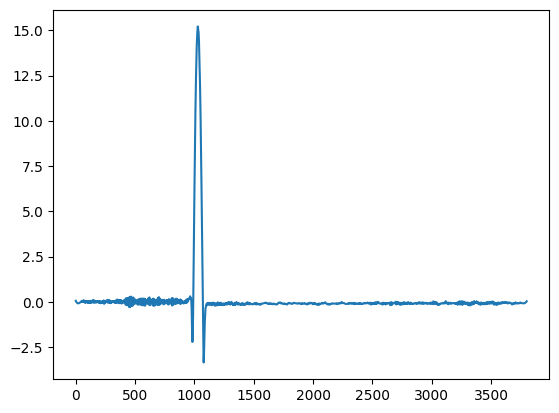

In [11]:
waveform_gradient = np.gradient(waveform)

smoothed_waveform_gradient = savgol_filter(waveform_gradient, window_length=100, polyorder=3)
fig, ax = plt.subplots()
ax.plot(time_index, smoothed_waveform_gradient)

In [12]:
print(f"Basic threshold tp0: {tp0_method1}")
print(f"Slope threshold tp0: {tp0_method2}")
print(f"Gradient peak start tp0: {tp0_method3}")
print(f"Ground truth tp0: {tp0_value}")

Basic threshold tp0: 996
Slope threshold tp0: 1023
Gradient peak start tp0: 987
Ground truth tp0: 943


In [13]:
estimated_tp0 = tp0_method3
peak_value = max(waveform)
peak_index = np.where(waveform == peak_value)[0][0]
waveform_rise = waveform[estimated_tp0:peak_index+1]
timeindex_rise = np.arange(0, peak_index - estimated_tp0 + 1)


In [14]:
from scipy.interpolate import interp1d

interpolated_waveform_function = interp1d(timeindex_rise, waveform_rise)
new_timeindex_rise = np.arange(0, len(timeindex_rise) - 1, 0.1)
new_waveform_rise = interpolated_waveform_function(new_timeindex_rise)


In [15]:
rise_peak = max(new_waveform_rise)
tdrift = np.where(new_waveform_rise >= (0.999 * rise_peak))[0][0]
tdrift50 = np.where(new_waveform_rise >= (0.5 * rise_peak))[0][0]
tdrift10 = np.where(new_waveform_rise >= (0.1 * rise_peak))[0][0]

In [16]:
print(f"tdrift: {tdrift}")
print(f"tdrift50: {tdrift50}")
print(f"tdrift10: {tdrift10}")

tdrift: 688
tdrift50: 426
tdrift10: 0


In [17]:
#pole zero correction
from scipy.optimize import curve_fit
def exponential(t, a, tau1, b, tau2):
    return a * np.exp(-t/tau1) + b * np.exp(-t/tau2)

peak_value = max(waveform)
t98 = np.where(waveform >= 0.98 * peak_value)[0][0]
tail_time = np.arange(0,time_index[-1] - t98 + 1)
tail_values = waveform[t98:]

params, params_cov = curve_fit(exponential, tail_time, tail_values)

f_decay = exponential(tail_time, *params)
f_t0 = np.mean(waveform[t98:t98+5])
f_pz = f_t0 / f_decay
waveform_tail_corrected = tail_values * f_pz

waveform_pz = waveform.copy()
waveform_pz[t98:] = waveform_tail_corrected

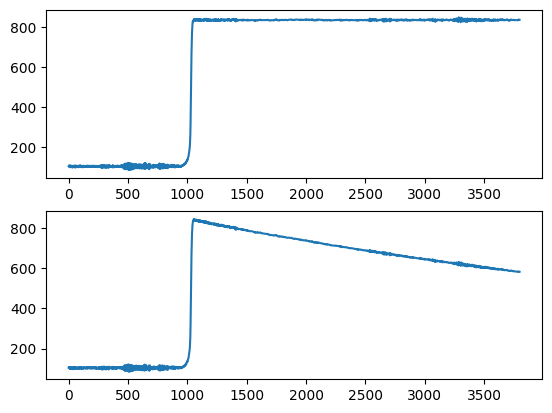

In [18]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(time_index, waveform_pz)
ax[1].plot(time_index, waveform)

In [19]:
#now to find lq80
tail_average = np.mean(waveform_tail_corrected)
t80 = np.where(waveform >= 0.80 * peak_value)[0][0]
tpeak = np.where(waveform >= peak_value)[0][0]

lq80_region = waveform[t80:tpeak+1]
tail_mean_threshold = np.ones(len(lq80_region)) * tail_average

waveform_underlq80 = np.trapezoid(lq80_region)
tail_mean_area = np.trapezoid(tail_mean_threshold)

lq80_region = tail_mean_area - waveform_underlq80

lq80_region


np.float64(502.5016281443677)

In [20]:
def extract_avse(wf, E, dt=4, window_ns=100, sg_window=11, sg_poly=3):
    """
    Extract AvsE (Amplitude vs Energy) from a waveform.
    
    Steps:
      1. Normalize waveform to [0, 1]
      2. Smooth waveform using Savitzky-Golay filter
      3. Compute current waveform using sliding window derivative
      4. Extract peak current amplitude (A)
      5. Compute total energy (E) as area under original waveform
      6. Return AvsE = A / E

    Parameters:
        wf : 1D np.array
            Input waveform (ADC values)
        dt : float
            Sampling period in ns (default 10 ns)
        window_ns : float
            Window size for slope (default 100 ns)
        sg_window : int
            Window length for Savitzky-Golay filter (must be odd)
        sg_poly : int
            Polynomial order for Savitzky-Golay filter

    Returns:
        AvsE : float
            Amplitude vs Energy parameter (dimensionless)
        A : float
            Peak current amplitude (normalized units/ns)
        E : float
            Total energy (ADC × ns)
        slopes : np.array
            Current waveform (slope at each time index)
        wnorm_smooth : np.array
            Smoothed normalized waveform
    """
    # Step 1: Normalize waveform to [0, 1]
    wmin, wmax = np.min(wf), np.max(wf)
    w_norm = (wf - wmin) / (wmax - wmin)

    # Step 2: Smooth waveform using Savitzky-Golay filter
    wnorm_smooth = savgol_filter(w_norm, sg_window, sg_poly)

    # Step 3: Compute current waveform using sliding window derivative
    N = int(window_ns / dt)  # number of samples in the window
    slopes = np.zeros(len(wnorm_smooth) - N)
    for i in range(len(slopes)):
        slopes[i] = (wnorm_smooth[i + N] - wnorm_smooth[i]) / (N * dt)

    # Step 4: Peak current amplitude (A)
    A = np.max(slopes)

    # Step 6: Compute AvsE
    AvsE = A / E

    return AvsE, A, E, slopes, wnorm_smooth

In [21]:
AvsE, A, E, slopes, wnorm_smooth = extract_avse(random_waveform, energy_value)
print(f"Extracted AvsE: {AvsE:5f}, A (current amplitude): {A:5f}, E (Energy): {E:5f}")

Extracted AvsE: 0.000028, A (current amplitude): 0.008252, E (Energy): 290.582553
